<a href="https://colab.research.google.com/github/Pranav-Raj-05/43611105/blob/main/Drug_Discovery_RD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 16.9 MB/s eta 0:00:00


In [5]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
    -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
!pip install torch_geometric


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html


Device: cuda

Loading QM9 dataset (regression)...


Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [02:42<00:00, 822.58it/s]
Done!



Loading MUTAG dataset (classification)...


Processing...
Done!


MUTAG class counts: [63, 125]
Using CrossEntropy weights: tensor([125.0000,  63.0000], device='cuda:0')
Epoch 01 | Reg TrainLoss 2.2799 | Val MAE 1.1455 | Val R2 -0.2602 | Clf TrainLoss 0.6958 | Val Acc 0.8000 | time 5.4s
Epoch 02 | Reg TrainLoss 1.0357 | Val MAE 0.8832 | Val R2 0.2671 | Clf TrainLoss 0.6906 | Val Acc 0.4667 | time 1.5s
Epoch 03 | Reg TrainLoss 0.8749 | Val MAE 0.8573 | Val R2 0.2853 | Clf TrainLoss 0.6856 | Val Acc 0.4667 | time 1.4s
Epoch 04 | Reg TrainLoss 0.8566 | Val MAE 0.8776 | Val R2 0.2837 | Clf TrainLoss 0.6828 | Val Acc 0.4667 | time 1.5s
Epoch 05 | Reg TrainLoss 0.8485 | Val MAE 0.8385 | Val R2 0.3036 | Clf TrainLoss 0.6816 | Val Acc 0.4667 | time 1.5s
Epoch 06 | Reg TrainLoss 0.8381 | Val MAE 0.8199 | Val R2 0.2854 | Clf TrainLoss 0.6779 | Val Acc 0.4667 | time 1.8s
[Scheduler:Clf] LR reduced from 0.001000 → 0.000500
Epoch 07 | Reg TrainLoss 0.8314 | Val MAE 0.8367 | Val R2 0.3186 | Clf TrainLoss 0.6764 | Val Acc 0.4667 | time 1.7s
Epoch 08 | Reg TrainLoss

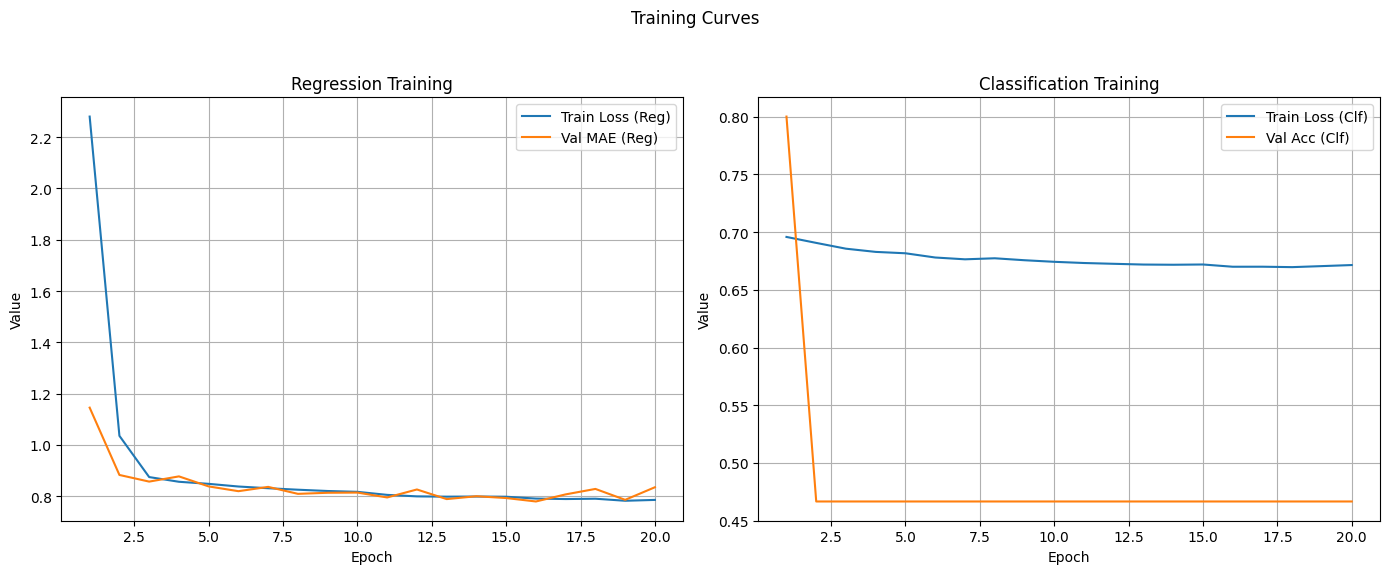

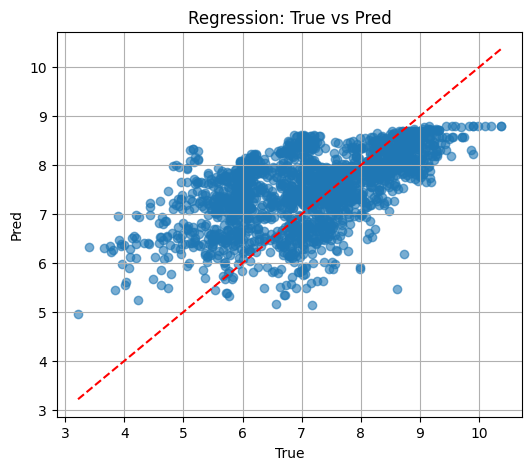

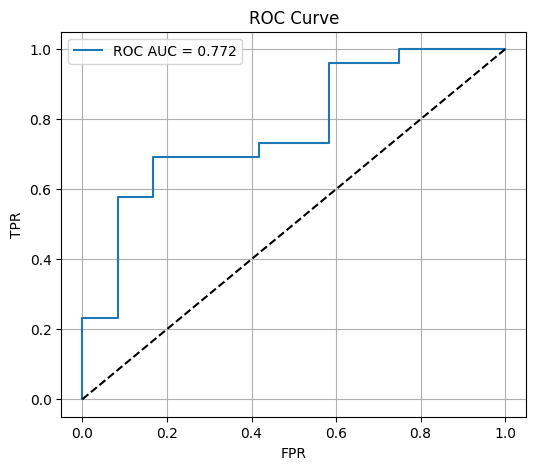

Confusion matrix:
 [[ 5  7]
 [ 6 20]]


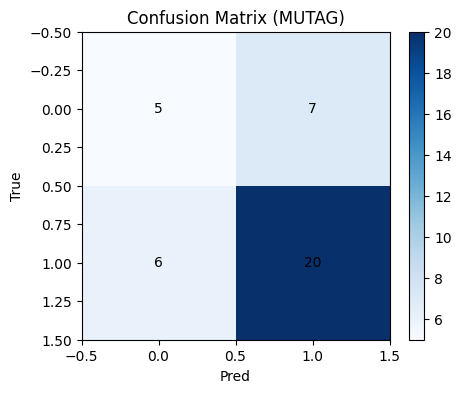

In [6]:
import os, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, roc_curve, auc
from torch_geometric.datasets import QM9, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

import warnings
warnings.filterwarnings(
    "ignore",
    message="It is not recommended to directly access the internal storage format `data`"
)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading QM9 dataset (regression)...")
qm9 = QM9(root="data/QM9")
target_idx = 4

print("\nLoading MUTAG dataset (classification)...")
mutag = TUDataset(root="data/MUTAG", name="MUTAG")
print("MUTAG class counts:", mutag.data.y.bincount().tolist())

train_reg_ds = qm9[:10000]
val_reg_ds   = qm9[10000:12000]
test_reg_ds  = qm9[12000:14000]

train_clf_ds = mutag[:120]
val_clf_ds   = mutag[120:150]
test_clf_ds  = mutag[150:]

train_reg = DataLoader(train_reg_ds, batch_size=64, shuffle=True)
val_reg   = DataLoader(val_reg_ds, batch_size=64)
test_reg  = DataLoader(test_reg_ds, batch_size=64)

train_clf = DataLoader(train_clf_ds, batch_size=32, shuffle=True)
val_clf   = DataLoader(val_clf_ds, batch_size=32)
test_clf  = DataLoader(test_clf_ds, batch_size=32)

class GCNNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, task="regression"):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_dim)
        self.task = task

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        out = self.lin(x)
        if self.task == "regression":
            return out.squeeze(-1)  # (batch,)
        else:
            return F.log_softmax(out, dim=-1)

in_dim_reg = train_reg_ds[0].x.shape[1]
in_dim_clf = train_clf_ds[0].x.shape[1]
n_classes = mutag.num_classes

model_reg = GCNNet(in_dim_reg, hidden_dim=64, out_dim=1, task="regression").to(device)
model_clf = GCNNet(in_dim_clf, hidden_dim=64, out_dim=n_classes, task="classification").to(device)

opt_reg = torch.optim.Adam(model_reg.parameters(), lr=1e-3, weight_decay=1e-5)
opt_clf = torch.optim.Adam(model_clf.parameters(), lr=1e-3, weight_decay=1e-5)

sched_reg = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_reg, mode='min', factor=0.5, patience=5)
sched_clf = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_clf, mode='min', factor=0.5, patience=5)

def step_scheduler(scheduler, optimizer, metric, name=""):
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(metric)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != prev_lr:
        print(f"[Scheduler:{name}] LR reduced from {prev_lr:.6f} → {new_lr:.6f}")

loss_reg_fn = nn.L1Loss()
class_counts = mutag.data.y.bincount().float().to(device)
inv_freq = (1.0 / (class_counts + 1e-12))
inv_freq = inv_freq * (class_counts.sum().float() / inv_freq.sum())
class_weights_ce = inv_freq.to(device)
print("Using CrossEntropy weights:", class_weights_ce)
loss_clf_fn = nn.NLLLoss(weight=class_weights_ce)

def train_epoch_reg():
    model_reg.train()
    total_loss = 0.0
    for data in train_reg:
        data = data.to(device)
        opt_reg.zero_grad()
        out = model_reg(data.x, data.edge_index, data.batch)
        target = data.y[:, target_idx].to(device).view(-1)
        loss = F.l1_loss(out, target)
        loss.backward()
        opt_reg.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_reg.dataset)

def eval_reg_return_preds(loader):
    model_reg.eval()
    ys, preds = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model_reg(data.x, data.edge_index, data.batch)
            ys.append(data.y[:, target_idx].cpu())
            preds.append(out.cpu())
    y_true = torch.cat(ys).numpy()
    y_pred = torch.cat(preds).numpy()
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, r2, y_true, y_pred

def train_epoch_clf():
    model_clf.train()
    total_loss = 0.0
    for data in train_clf:
        data = data.to(device)
        opt_clf.zero_grad()
        out = model_clf(data.x, data.edge_index, data.batch)
        target = data.y.view(-1).long().to(device)
        loss = loss_clf_fn(out, target)
        loss.backward()
        opt_clf.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_clf.dataset)

def eval_clf_return_preds(loader):
    model_clf.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out_log = model_clf(data.x, data.edge_index, data.batch)
            prob = out_log.exp().cpu()
            pred = prob.argmax(dim=1).cpu()
            ys.append(data.y.view(-1).cpu())
            preds.append(pred)
            probs.append(prob)
    y_true = torch.cat(ys).numpy()
    y_pred = torch.cat(preds).numpy()
    probs_all = torch.cat(probs).numpy()
    if n_classes == 2:
        y_scores = probs_all[:,1]
    else:
        y_scores = probs_all.max(axis=1)
    acc = (y_true == y_pred).mean()
    return acc, y_true, y_pred, y_scores

EPOCHS = 20
history = {
    'reg_train_loss': [], 'reg_val_mae': [], 'reg_val_r2': [],
    'clf_train_loss': [], 'clf_val_acc': []
}

best_val_mae = float('inf'); best_epoch_reg = 0
best_val_acc = 0.0; best_epoch_clf = 0
early_stop_patience = 8

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss_reg = train_epoch_reg()
    val_mae, val_r2, _, _ = eval_reg_return_preds(val_reg)
    step_scheduler(sched_reg, opt_reg, val_mae, name="Reg")

    tr_loss_clf = train_epoch_clf()
    val_acc, _, _, _ = eval_clf_return_preds(val_clf)
    step_scheduler(sched_clf, opt_clf, 1.0 - val_acc, name="Clf")

    history['reg_train_loss'].append(tr_loss_reg)
    history['reg_val_mae'].append(val_mae)
    history['reg_val_r2'].append(val_r2)
    history['clf_train_loss'].append(tr_loss_clf)
    history['clf_val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d} | Reg TrainLoss {tr_loss_reg:.4f} | Val MAE {val_mae:.4f} | Val R2 {val_r2:.4f} | Clf TrainLoss {tr_loss_clf:.4f} | Val Acc {val_acc:.4f} | time {time.time()-t0:.1f}s")

    if val_mae < best_val_mae - 1e-6:
        best_val_mae = val_mae; best_epoch_reg = epoch
        torch.save(model_reg.state_dict(), "best_reg.pth")
    if val_acc > best_val_acc + 1e-6:
        best_val_acc = val_acc; best_epoch_clf = epoch
        torch.save(model_clf.state_dict(), "best_clf.pth")

    if (epoch - best_epoch_reg >= early_stop_patience) and (epoch - best_epoch_clf >= early_stop_patience):
        print("Early stopping both tasks.")
        break

if os.path.exists("best_reg.pth"):
    model_reg.load_state_dict(torch.load("best_reg.pth"))
if os.path.exists("best_clf.pth"):
    model_clf.load_state_dict(torch.load("best_clf.pth"))

test_mae, test_r2, y_true_reg, y_pred_reg = eval_reg_return_preds(test_reg)
test_acc, y_true_clf, y_pred_clf, y_scores_clf = eval_clf_return_preds(test_clf)

print("\nFinal Test Results:")
print(f"Regression MAE (QM9 target {target_idx}): {test_mae:.4f} | R2: {test_r2:.4f}")
print(f"Classification Acc (MUTAG): {test_acc:.4f}")

epochs = range(1, len(history['reg_train_loss'])+1)
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(epochs, history['reg_train_loss'], label='Train Loss (Reg)')
plt.plot(epochs, history['reg_val_mae'], label='Val MAE (Reg)')
plt.title('Regression Training')
plt.xlabel('Epoch'); plt.ylabel('Value'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, history['clf_train_loss'], label='Train Loss (Clf)')
plt.plot(epochs, history['clf_val_acc'], label='Val Acc (Clf)')
plt.title('Classification Training')
plt.xlabel('Epoch'); plt.ylabel('Value'); plt.legend(); plt.grid(True)

plt.suptitle('Training Curves')
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(y_true_reg, y_pred_reg, alpha=0.6)
mn, mx = min(y_true_reg.min(), y_pred_reg.min()), max(y_true_reg.max(), y_pred_reg.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.title('Regression: True vs Pred')
plt.xlabel('True'); plt.ylabel('Pred'); plt.grid(True)
plt.show()

if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_true_clf, y_scores_clf)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid(True)
    plt.show()

cm = confusion_matrix(y_true_clf, y_pred_clf)
print("Confusion matrix:\n", cm)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix (MUTAG)")
plt.xlabel("Pred"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()
